# Adaptive Boosting (AdaBoost)

In this notebook, we present the Adaptive Boosting (AdaBoost) algorithm. The
aim is to get intuitions regarding the internal machinery of AdaBoost and
boosting in general.

We will load the "penguin" dataset. We will predict penguin species from the
culmen length and depth features.

In [2]:
import pandas as pd

url = 'https://raw.githubusercontent.com/wamanagba/Data/main/penguins_classification.csv'
penguins = pd.read_csv(url)

#penguins = pd.read_csv("../datasets/penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

data, target = penguins[culmen_columns], penguins[target_column]
range_features = {
    feature_name: (data[feature_name].min() - 1, data[feature_name].max() + 1)
    for feature_name in data.columns}

In addition, we are also using the function used in the previous notebook
to plot the decision function of the tree.

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")

    return ax

We will purposefully train a shallow decision tree. Since it is shallow,
it is unlikely to overfit and some of the training examples will even be
misclassified.

In [4]:
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

palette = ["tab:red", "tab:blue", "black"]

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data, target)

DecisionTreeClassifier(max_depth=2, random_state=0)

We can predict on the same dataset and check which samples are misclassified.

In [5]:
target_predicted = tree.predict(data)
misclassified_samples_idx = np.flatnonzero(target != target_predicted)
data_misclassified = data.iloc[misclassified_samples_idx]

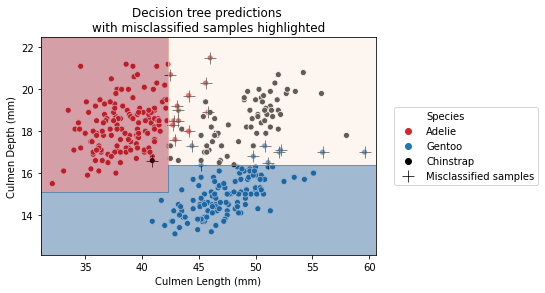

In [6]:
# plot the original dataset
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
# plot the misclassified samples
ax = sns.scatterplot(data=data_misclassified, x=culmen_columns[0],
                     y=culmen_columns[1], label="Misclassified samples",
                     marker="+", s=150, color="k")
plot_decision_function(tree, range_features, ax=ax)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Decision tree predictions \nwith misclassified samples "
              "highlighted")

We observe that several samples have been misclassified by the classifier.

We mentioned that boosting relies on creating a new classifier which tries to
correct these misclassifications. In scikit-learn, learners have a
parameter `sample_weight` which forces it to pay more attention to
samples with higher weights during the training.

This parameter is set when calling
`classifier.fit(X, y, sample_weight=weights)`.
We will use this trick to create a new classifier by 'discarding' all
correctly classified samples and only considering the misclassified samples.
Thus, misclassified samples will be assigned a weight of 1 and well
classified samples will be assigned a weight of 0.

In [7]:
sample_weight = np.zeros_like(target, dtype=int)
sample_weight[misclassified_samples_idx] = 1

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data, target, sample_weight=sample_weight)

DecisionTreeClassifier(max_depth=2, random_state=0)

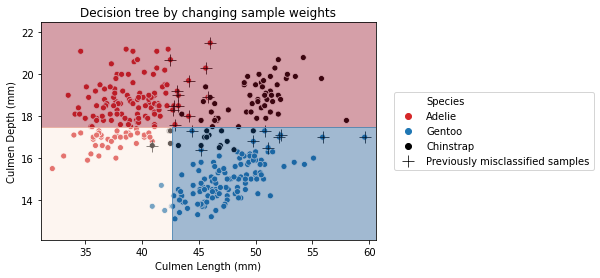

In [8]:
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
ax = sns.scatterplot(data=data_misclassified, x=culmen_columns[0],
                     y=culmen_columns[1],
                     label="Previously misclassified samples",
                     marker="+", s=150, color="k")
plot_decision_function(tree, range_features, ax=ax)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Decision tree by changing sample weights")

We see that the decision function drastically changed. Qualitatively, we see
that the previously misclassified samples are now correctly classified.

In [9]:
target_predicted = tree.predict(data)
newly_misclassified_samples_idx = np.flatnonzero(target != target_predicted)
remaining_misclassified_samples_idx = np.intersect1d(
    misclassified_samples_idx, newly_misclassified_samples_idx
)

print(f"Number of samples previously misclassified and "
      f"still misclassified: {len(remaining_misclassified_samples_idx)}")

Number of samples previously misclassified and still misclassified: 0


However, we are making mistakes on previously well classified samples. Thus,
we get the intuition that we should weight the predictions of each classifier
differently, most probably by using the number of mistakes each classifier
is making.

So we could use the classification error to combine both trees.

In [10]:
ensemble_weight = [
    (target.shape[0] - len(misclassified_samples_idx)) / target.shape[0],
    (target.shape[0] - len(newly_misclassified_samples_idx)) / target.shape[0],
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

The first classifier was 94% accurate and the second one 69% accurate.
Therefore, when predicting a class, we should trust the first classifier
slightly more than the second one. We could use these accuracy values to
weight the predictions of each learner.

To summarize, boosting learns several classifiers, each of which will
focus more or less on specific samples of the dataset. Boosting is thus
different from bagging: here we never resample our dataset, we just assign
different weights to the original dataset.

Boosting requires some strategy to combine the learners together:

* one needs to define a way to compute the weights to be assigned
  to samples;
* one needs to assign a weight to each learner when making predictions.

Indeed, we defined a really simple scheme to assign sample weights and
learner weights. However, there are statistical theories (like in AdaBoost)
for how these sample and learner weights can be optimally calculated.

We will use the AdaBoost classifier implemented in scikit-learn and
look at the underlying decision tree classifiers trained.

In [11]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(base_estimator=base_estimator,
                              n_estimators=3, algorithm="SAMME",
                              random_state=0)
adaboost.fit(data, target)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=0),
                   n_estimators=3, random_state=0)

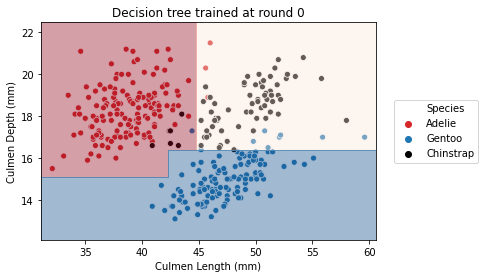

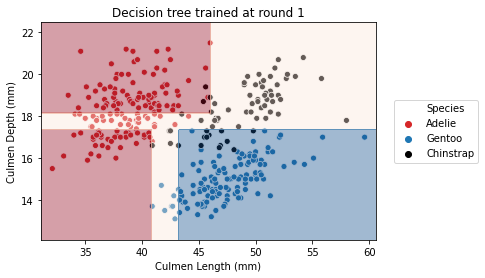

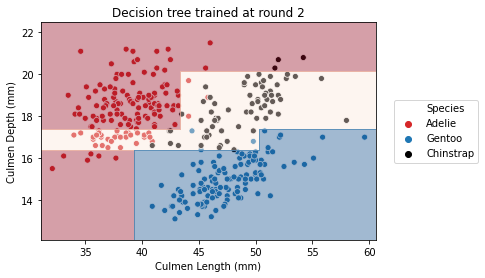

In [12]:
for boosting_round, tree in enumerate(adaboost.estimators_):
    plt.figure()
    ax = sns.scatterplot(x=culmen_columns[0], y=culmen_columns[1],
                         hue=target_column, data=penguins,
                         palette=palette)
    plot_decision_function(tree, range_features, ax=ax)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    _ = plt.title(f"Decision tree trained at round {boosting_round}")

In [13]:
print(f"Weight of each classifier: {adaboost.estimator_weights_}")

Weight of each classifier: [3.58351894 3.46901998 3.03303773]


In [14]:
print(f"Error of each classifier: {adaboost.estimator_errors_}")

Error of each classifier: [0.05263158 0.05864198 0.08787269]


We see that AdaBoost learned three different classifiers, each of which
focuses on different samples. Looking at the weights of each learner, we see
that the ensemble gives the highest weight to the first classifier. This
indeed makes sense when we look at the errors of each classifier. The first
classifier also has the highest classification statistical performance.

While AdaBoost is a nice algorithm to demonstrate the internal machinery of
boosting algorithms, it is not the most efficient.
This title is handed to the gradient-boosting decision tree (GBDT) algorithm,
which we will discuss after a short exercise.